# Ethereum Sender Address Analysis - Bear Phases between 2015 - 2021
- by Malik Sogukoglu

## References
- Inspiration for Workflow structure: 
 - https://www.bmc.com/blogs/python-spark-k-means-example/
 - https://www.kaggle.com/statsfromarg/btc-data-exploratory-analysis-with-txn
- K-means clustering in Spark
 - https://spark.apache.org/docs/latest/ml-clustering.html
 - https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b
- Sampling:
 - https://stackoverflow.com/questions/24806084/sampling-a-large-distributed-data-set-using-pyspark-spark
- Filter pushdown: 
 - https://engineering.dynatrace.com/blog/optimizing-spark-queries-with-filter-pushdown/
 - https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
- Read data: 
 - Reading several files: https://stackoverflow.com/questions/49898742/pandas-reading-csv-files-with-partial-wildcard
 - Correct processing of the date value as part of filtering (1): https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime 
 - Correct processing of the date value as part of filtering(2) :https://stackoverflow.com/questions/19801727/convert-datetime-to-unix-timestamp-and-convert-it-back-in-python
- In-memory data processing:
 - https://phoenixnap.com/kb/hadoop-vs-spark 
- Disable infer schema
 - https://stackoverflow.com/questions/56927329/spark-option-inferschema-vs-header-true/56933052
- PCA: 
 - https://stackoverflow.com/questions/59883306/how-to-drop-a-column-from-a-spark-dataframe-by-index-where-column-names-can-be-d
 - pca plot variance explained https://datascience-enthusiast.com/Python/PCA_Spark_Python_R
- Plots:
 - 3-D Plots: help received from https://stackoverflow.com/questions/37711538/matplotlib-3d-axes-ticks-labels-and-latex
            


## Set up environment

In [1]:
!pip install pyspark



In [32]:
from pyspark.sql import SparkSession


In [33]:
import glob

In [35]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType

In [36]:
from pyspark.sql import functions as F

## Define data schema

In [37]:
schema = StructType([ \
    StructField("sender",StringType(),True), \
    StructField("value",IntegerType(),True), \
    StructField("timestamp_in_unix_seconds",IntegerType(),True), \
    StructField("fee",IntegerType(),True), \
  ])

## Set configurations
- Amount of **executors is set to 4**, enabling **parallel processing**
- **Executors** are allocated with **8GB RAM**
- **Spark driver** is allocated with **16GB RAM**
- **Filter pushdown** is enabled, to prevent not requested data to be loaded into memory

In [38]:
from pyspark.conf import SparkConf


config = SparkConf().setAll([ \
    ('spark.executor.memory', '8g'), \
    ("spark.executor.instances", "4"), \

    ('spark.driver.memory','16g'), \
    ("spark.sql.parquet.filterPushdown", "true"), \
    ("spark.hadoop.parquet.filter.stats.enabled", "true"), \
    ("spark.sql.optimizer.nestedSchemaPruning.enabled", "true"), \
    ("spark.sql.optimizer.dynamicPartitionPruning.enabled", "true"), \
    ("spark.sql.autoBroadcastJoinThreshold", "-1"), \
    ("spark.sql.parquet.binaryAsString", "true") ]) \
#    ("spark.executor.memoryOverhead", "16384") \


## Open Spark session

In [39]:
print(config.setMaster("local").setAppName("Clustering using K-Means"))

print(config.get("spark.master"))

print(config.get("spark.app.name"))


local
Clustering using K-Means


In [40]:
import time

from datetime import datetime
spark = SparkSession.builder.appName("Clustering using K-Means") \
    .config(conf=config) \
    .getOrCreate() \
#    .option("failOnDataLoss", False)

In [41]:
spark

### Check applied configurations

In [42]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.executor.instances', '4'),
 ('spark.sql.parquet.binaryAsString', 'true'),
 ('spark.driver.port', '50212'),
 ('spark.sql.parquet.filterPushdown', 'true'),
 ('spark.app.id', 'local-1639418990993'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.optimizer.dynamicPartitionPruning.enabled', 'true'),
 ('spark.driver.memory', '16g'),
 ('spark.sql.optimizer.nestedSchemaPruning.enabled', 'true'),
 ('spark.sql.warehouse.dir',
  'file:/D:/Submission%20folder/Ethereum%20analysis/spark-warehouse'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.hadoop.parquet.filter.stats.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '-1'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.startTime', '1639418988638'),
 ('spark.app.name', 'Clustering using K-Means'),
 ('spark.driver.host', '10.0.7.40')]

## Indicate data to be read

In [43]:
import glob
import os
BITCOIN_PATHS = sorted(glob.glob(os.path.join("D:\\Downloads\\ethereum_data\\", "ethereum*.csv")))
BITCOIN_PATHS

['D:\\Downloads\\ethereum_data\\ethereum000000000000.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000001.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000002.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000003.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000004.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000005.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000006.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000007.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000008.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000009.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000010.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000011.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000012.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000013.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000014.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000015.csv',
 'D:\\Downloads\\ethereum_data\\ethereum000000000016.csv

## Load Ethereum data into Spark
- Select the columns **Sender**, **Value** and **Fee**.
- Filter by timestamp (**timestamp_in_unix_time**).
- Reshuffle +  Sample data with **factor 0.1**
- Discard NAs
- Load data into cache (with persist()) to avoid having to reload data for different analyses

In [44]:
data_customer=spark.read.csv(BITCOIN_PATHS, header=True, schema=schema) \
    .select("sender","value","fee") \
    .filter( \
        ((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2017-12-18', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2018-12-16', '%Y-%m-%d').timetuple())))) |\
        ((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2021-04-13', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2021-07-20', '%Y-%m-%d').timetuple())))) \
            
           ) \
    .sample(False,0.1,1234) \
    .na.drop() \
    .persist()
data_customer.printSchema()

root
 |-- sender: string (nullable = true)
 |-- value: integer (nullable = true)
 |-- fee: integer (nullable = true)



## Show explanation of data loading plan
Here Spark shows how it will approach the data loading process, defined above

In [45]:
data_customer.explain()

== Physical Plan ==
InMemoryTableScan [sender#6064, value#6065, fee#6067]
   +- InMemoryRelation [sender#6064, value#6065, fee#6067], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Filter AtLeastNNulls(n, sender#6064,value#6065,fee#6067)
            +- *(1) Sample 0.0, 0.1, false, 1234
               +- *(1) Project [sender#6064, value#6065, fee#6067]
                  +- *(1) Filter (((timestamp_in_unix_seconds#6066 >= 1513551600) AND (timestamp_in_unix_seconds#6066 <= 1544914800)) OR ((timestamp_in_unix_seconds#6066 >= 1618264800) AND (timestamp_in_unix_seconds#6066 <= 1626732000)))
                     +- FileScan csv [sender#6064,value#6065,timestamp_in_unix_seconds#6066,fee#6067] Batched: false, DataFilters: [(((timestamp_in_unix_seconds#6066 >= 1513551600) AND (timestamp_in_unix_seconds#6066 <= 15449148..., Format: CSV, Location: InMemoryFileIndex[file:/D:/Downloads/ethereum_data/ethereum000000000000.csv, file:/D:/Downloads/e..., PartitionFilters: [], Pushe

## Show two examples of data loaded into Spark.

In [46]:
data_customer.show(2)

+--------------------+----------+------+
|              sender|     value|   fee|
+--------------------+----------+------+
|0xe2d83239393b985...|1785350475|     0|
|0x15fba53fcf4f533...|   6486141|147525|
+--------------------+----------+------+
only showing top 2 rows



## Add feature: amount of transactions performed per sender ("c") into dataset

In [47]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)
sqlContext.registerDataFrameAsTable(data_customer, "table1")
df2 = sqlContext.sql(" \
                     with counted_sender as (SELECT sender, count(*) as c \
                     from table1 group by sender) \
                     select table1.sender, avg(value) as avg_value, avg(fee) as avg_fee, c \
                     from table1 join counted_sender on table1.sender=counted_sender.sender \
                     group by table1.sender, c order by c desc"
                    )

In [48]:
# sender are filtered out, since they are hash values --> do not contain any structure
inputCols=['avg_value', 'avg_fee', 'c']


## Perform Vector Assembler to put the features into suitable format for subsequent K-Means clustering and PCA executions.
Note: Senders are filtered out, since these are hash values, i.e., categorical values, that do not contain any structure to be determined by Clustering + PCA

In [49]:

from pyspark.ml.feature import VectorAssembler
df2.columns
assemble=VectorAssembler(inputCols=inputCols, outputCol='features')
assembled_data=assemble.transform(df2)
assembled_data.show(2)

+--------------------+---------+-----------------+---+--------------------+
|              sender|avg_value|          avg_fee|  c|            features|
+--------------------+---------+-----------------+---+--------------------+
|0xa073cfdc059caf1...|      1.0|         101808.0|125|[1.0,101808.0,125.0]|
|0x0c462ed55a7d553...|      1.0|99339.13043478261|115|[1.0,99339.130434...|
+--------------------+---------+-----------------+---+--------------------+
only showing top 2 rows



## Standardise data (including mean-centring and scaling)

In [50]:

from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized', withMean=True, withStd=True)
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+--------------------+---------+-----------------+---+--------------------+--------------------+
|              sender|avg_value|          avg_fee|  c|            features|        standardized|
+--------------------+---------+-----------------+---+--------------------+--------------------+
|0xa073cfdc059caf1...|      1.0|         101808.0|125|[1.0,101808.0,125.0]|[-0.1252655623263...|
|0x0c462ed55a7d553...|      1.0|99339.13043478261|115|[1.0,99339.130434...|[-0.1252655623263...|
+--------------------+---------+-----------------+---+--------------------+--------------------+
only showing top 2 rows



## Perform PCA
- 3 PCs to be created

In [51]:
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
pca = PCA(k=3, inputCol="standardized")
pca.setOutputCol("pca_features")
model = pca.fit(data_scale_output)
data_scale_output = model.transform(data_scale_output)

In [52]:
data_scale_output.show(2)

+--------------------+---------+-----------------+---+--------------------+--------------------+--------------------+
|              sender|avg_value|          avg_fee|  c|            features|        standardized|        pca_features|
+--------------------+---------+-----------------+---+--------------------+--------------------+--------------------+
|0xa073cfdc059caf1...|      1.0|         101808.0|125|[1.0,101808.0,125.0]|[-0.1252655623263...|[-8.7737335603174...|
|0x0c462ed55a7d553...|      1.0|99339.13043478261|115|[1.0,99339.130434...|[-0.1252655623263...|[-8.0497610923123...|
+--------------------+---------+-----------------+---+--------------------+--------------------+--------------------+
only showing top 2 rows



## Variance explained by the 3 PCs
Order: PC1, PC2, PC3

In [53]:
model.explainedVariance

DenseVector([0.3596, 0.3297, 0.3107])

## Features explaining the PCs

In [54]:
import numpy as np
import pandas as pd
pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC'+str(i) for i in range(1, 4)], index = inputCols)
df_pc


,PC1,PC2,PC3
avg_value,-0.6663,0.2217,-0.7120
avg_fee,-0.3487,-0.9366,0.0347
c,-0.6591,0.2714,0.7014


## Perform K-Means clusterings while evaluating each of them
- In order to find the ideal clustering, k-means was performed several times by each time selecting a different number of clusters (k) to be formed, and by performing a respective evaluation based on silhouette score.

- The process lasted 26min 36s

In [ ]:
%%time
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i, seed=1) # set seed
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

## The diagram below shows the silhouette score achieved by the different clusterings, with a different k chosen each time.

Text(0, 0.5, 'silhouette score')

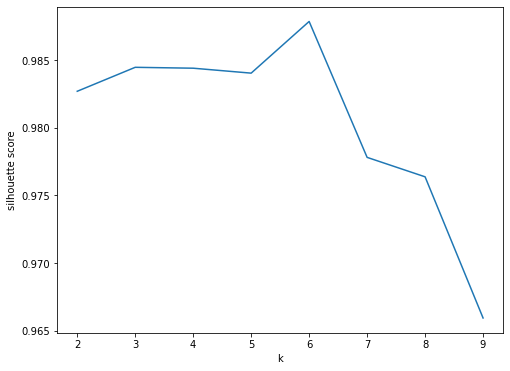

In [56]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("silhouette score")

## The optimal number of clusters (K) was chosen to be 4, and on this basis the data points in the dataset were assigned to the clusters.¶

In [57]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans(featuresCol='standardized').setK(4).setSeed(1)
model = kmeans.fit(data_scale_output)

# Make predictions
predictions = model.transform(data_scale_output)


## The data in Spark is fetched back into the Python environment using "toPandas" conversion. 
This is done to then realize visualization on Python environment.

In [58]:

pandasDF=predictions.toPandas()

## A graph based on the original dataset is created

In [59]:

x = []
y = []
z = []
for i, j, k in pandasDF["standardized"].values:
    x.append(i)
    y.append(j)
    z.append(k)

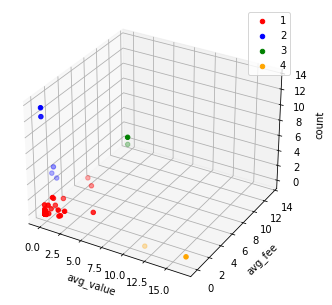

In [60]:
import matplotlib.pyplot as plt

import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
scatter_x = np.array(x) # scaled bitcoin transaction avg_value
scatter_y = np.array(y) # scaled bitcoin transaction avg_fee
scatter_z = np.array(z) # scaled bitcoin transaction count
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
#fig, ax = plt.subplots()
fig = pyplot.figure()
ax = Axes3D(fig)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("avg_value")
plt.ylabel("avg_fee")
ax.set_zlabel("count")
plt.show()
